In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#  Load Muscle Activation Dataset

The Muscle Activation dataset was collected from professional in-line speed skating on a large motor driven treadmill with Electromyography (EMG) data of multiple movements. It consists of $29.899$ measurements at $100Hz$ corresponding to $30s$ in total. The known motifs are the muscle movement and a recovery phase.


### References
- [1] https://link.springer.com/content/pdf/10.1007/s10618-007-0070-1.pdf
- [2] http://www.cs.ucr.edu/~eamonn/iSAX/iSAX.html

Dataset Original Length n:  14950
Dataset Sampled Length n:  14950
../datasets/ground_truth/muscle_activation_gt.csv


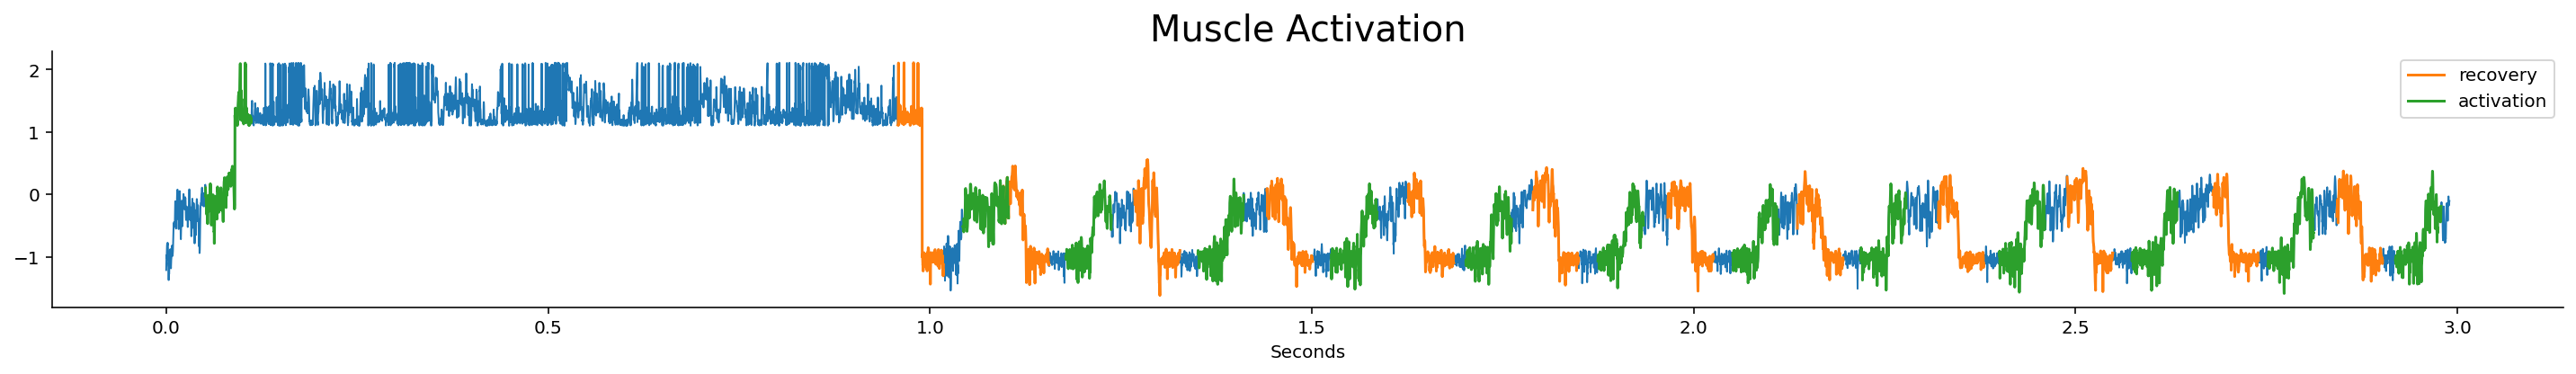

In [2]:
file = 'muscle_activation.csv'
ds_name = "Muscle Activation"
series, df_gt = ml.read_dataset_with_index(file)
data = series.values
# series = ml.as_series(data, np.arange(0, 29899, 2) / 10000, 'Seconds')
plot_dataset(ds_name, series, ground_truth=df_gt)

# Known Motifs

The known motifs are the muscle movement activation and a recovery phase of the Gluteus Maximus muscle and have $13$ and $12$ occurrences, respectively.

See: *Mörchen, Fabian, and Alfred Ultsch. "Efficient mining of understandable patterns from multivariate interval time series." Data mining and knowledge discovery 15.2 (2007): 181-215.
APA*


# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2

rerun_all_jars = False
ks = 15
dataset = os.getcwd() + '/../datasets/' + file
print(dataset, len(series))

/Users/bzcschae/workspace/motiflets_paper/notebooks/../datasets/muscle_activation.csv 14950


# k-Motiflets

## First, we learn the motif length l

We find a minimum around $l=1.2s$.

Compute ks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 21.41it/s]


	Time 7.2 s


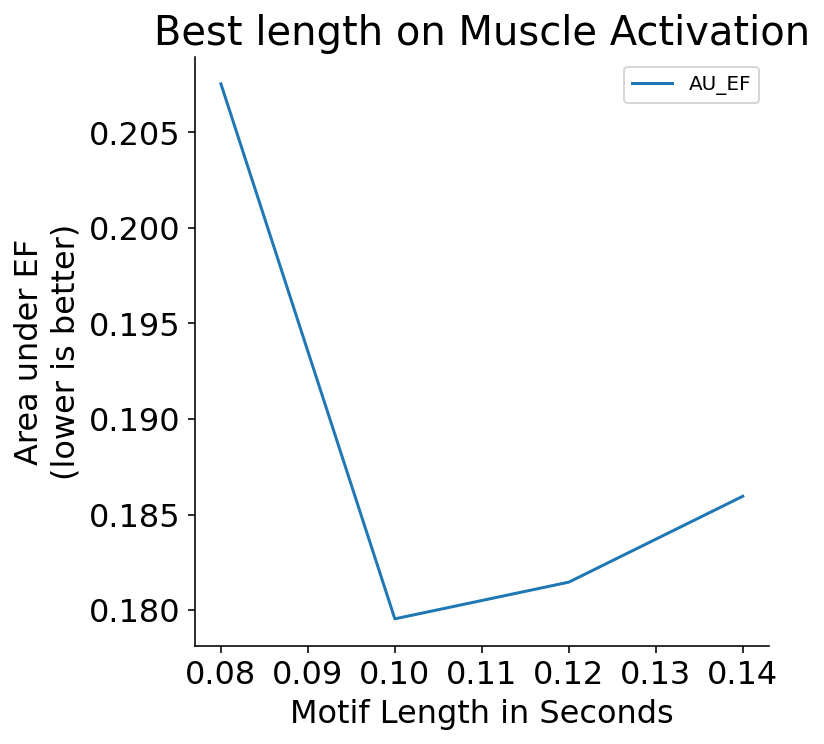

Found motif length 500


In [4]:
length_range = np.arange(400,701,100) 
motif_length = plot_motif_length_selection(
    ks, series, length_range, ds_name=ds_name)

print ("Found motif length", motif_length)

## Next, we learn the size k of the motif set

We plot the similarity of the motifs as a function of the cardinality of $k$-Motiflets to their extent. Elbow points represent large changes in similarity of the found motif set, indicative of a concept change from calibrations signal to heartbeats.

In the following plots, we found two characteristic motifs: activations with $13$ repetitions and recovery with $12$ repetitions.

Data 14950


Compute ks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  6.22it/s]


Chosen window-size: 500 in 3.7 s
Elbow Points [12]


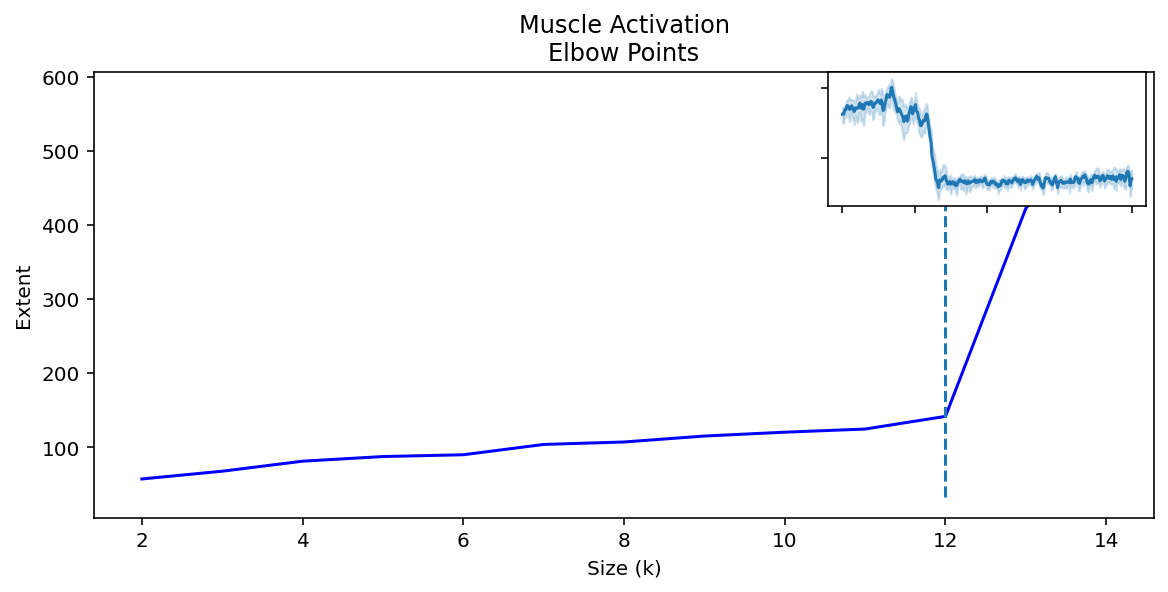

Data 14950


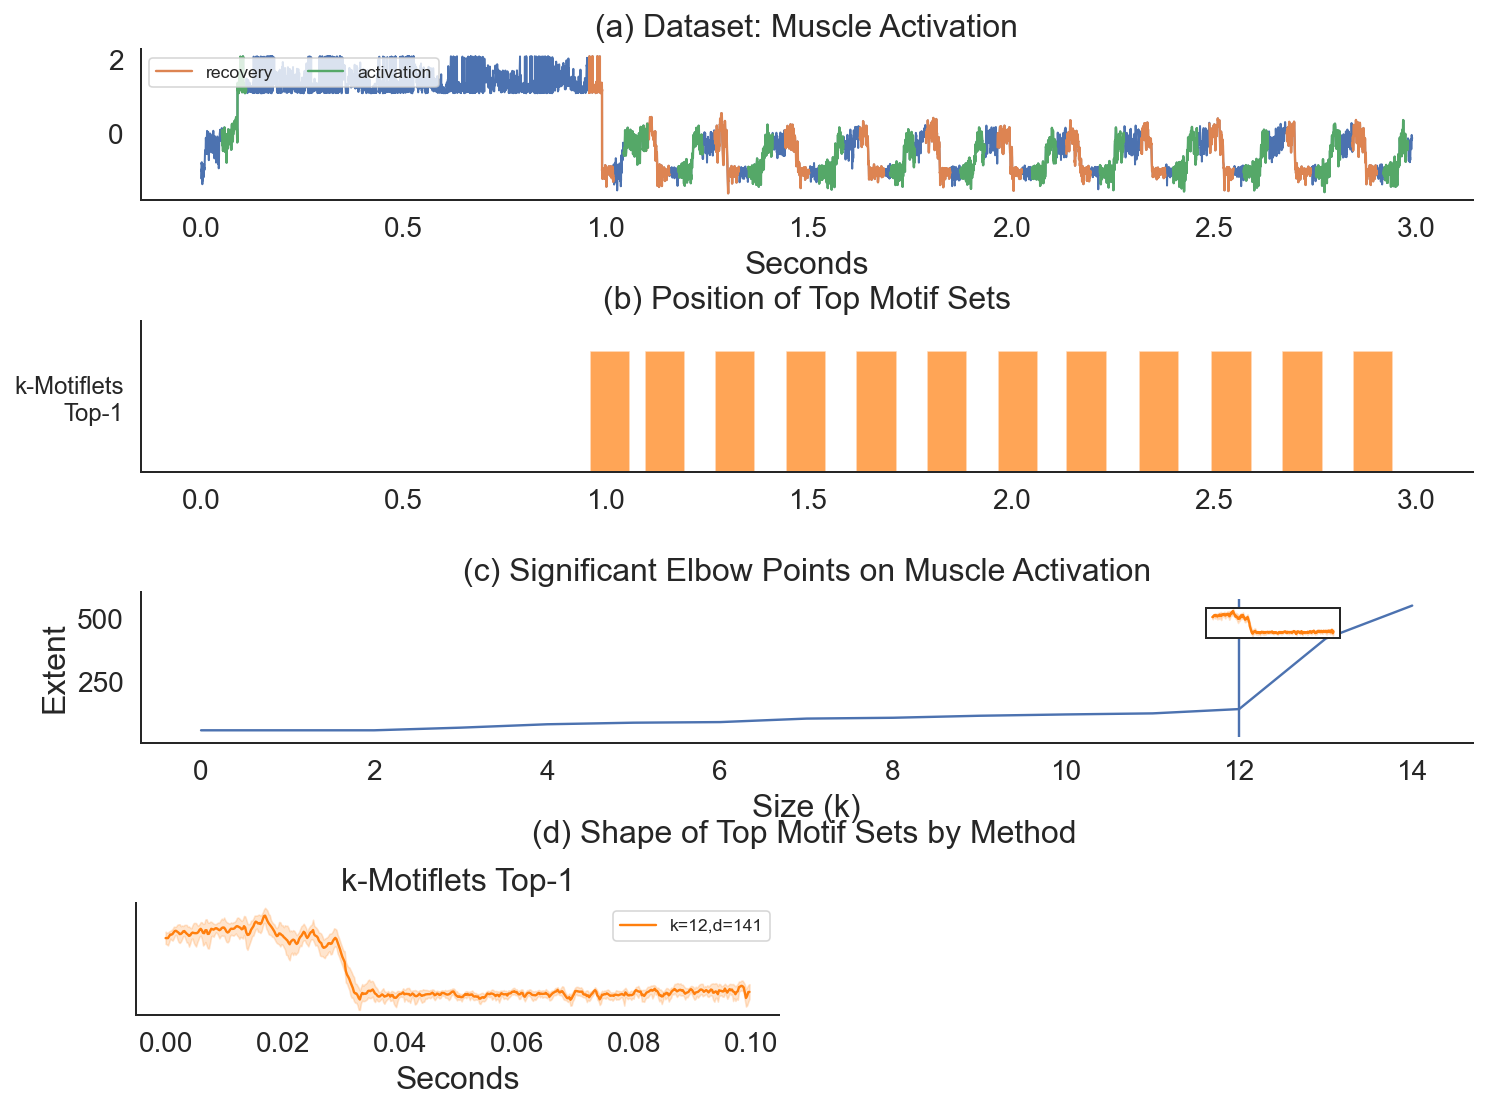

In [5]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="k-Motiflets", ground_truth=df_gt)

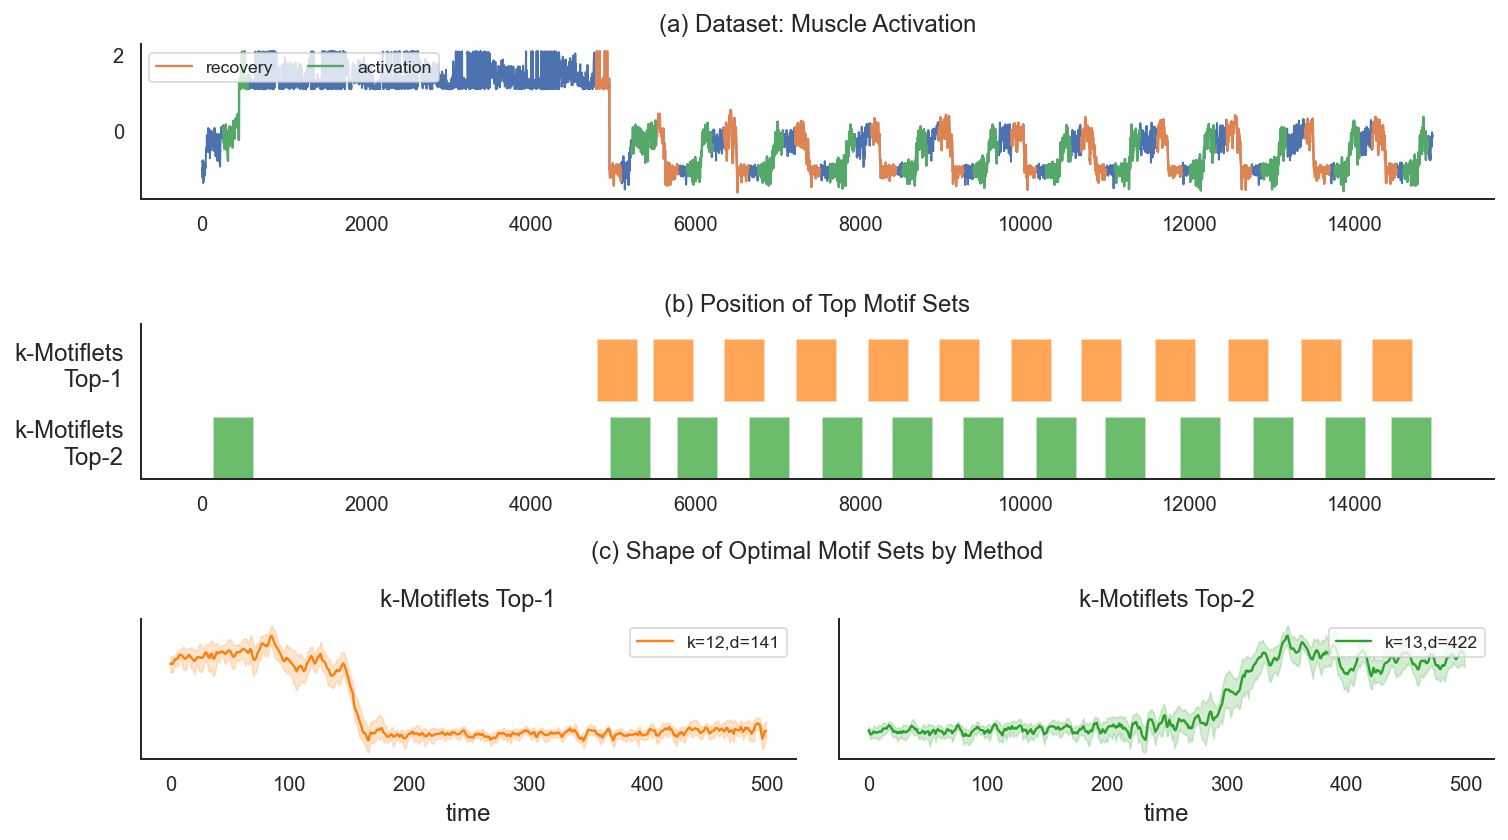

In [6]:
# 13 is no elbow point, thus we add it manually
elbow_points = [12, 13]
                
plot_grid_motiflets(
        ds_name, data, motiflets, elbow_points,
        dists, motif_length, show_elbows=False,
        ground_truth=df_gt, method_name="k-Motiflets")

# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. 

We use the results of $k$-Motiflets as silver standard and compare the ability of the other methods to recover the respective motifs. To enable such a comparison, we provided the competitors with proper values of $r$ and $l$, derived from the silver standard, but also with an added noise of $-10\%$ and $+10\%$ to reflect trial-and-error tuning.

In [7]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]

r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])

print("Radius of TOP-1 Motif", r_top1, r_top2)
print("Extent of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

radii = np.array([r_top2, r_top1])
print("Radii r", radii)

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

# Human error due to trial-and-error
errors = [0, -0.10, 0.10]

Radius of TOP-1 Motif 236.59426879882812 113.4172134399414
Extent of TOP-1 Motif 422.44122314453125
Radii r [113.41721344 236.5942688 ]
Best Radii	 [113.41721344 236.5942688 ]
Best Lengths	 500


# Competitors

We compare our $k$-Motiflets to the state-of-the-art motif set discovery methods. These are based on different definitions as follow:

<img src="images/motif_definitions.png"/>

# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [8]:
rs = np.array([r_top2 * 2.5, r_top1 * 1.145])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/set_finder.jar',
           dataset,
           'SetFinder',
           str(list(rs)),
           str(mls)])

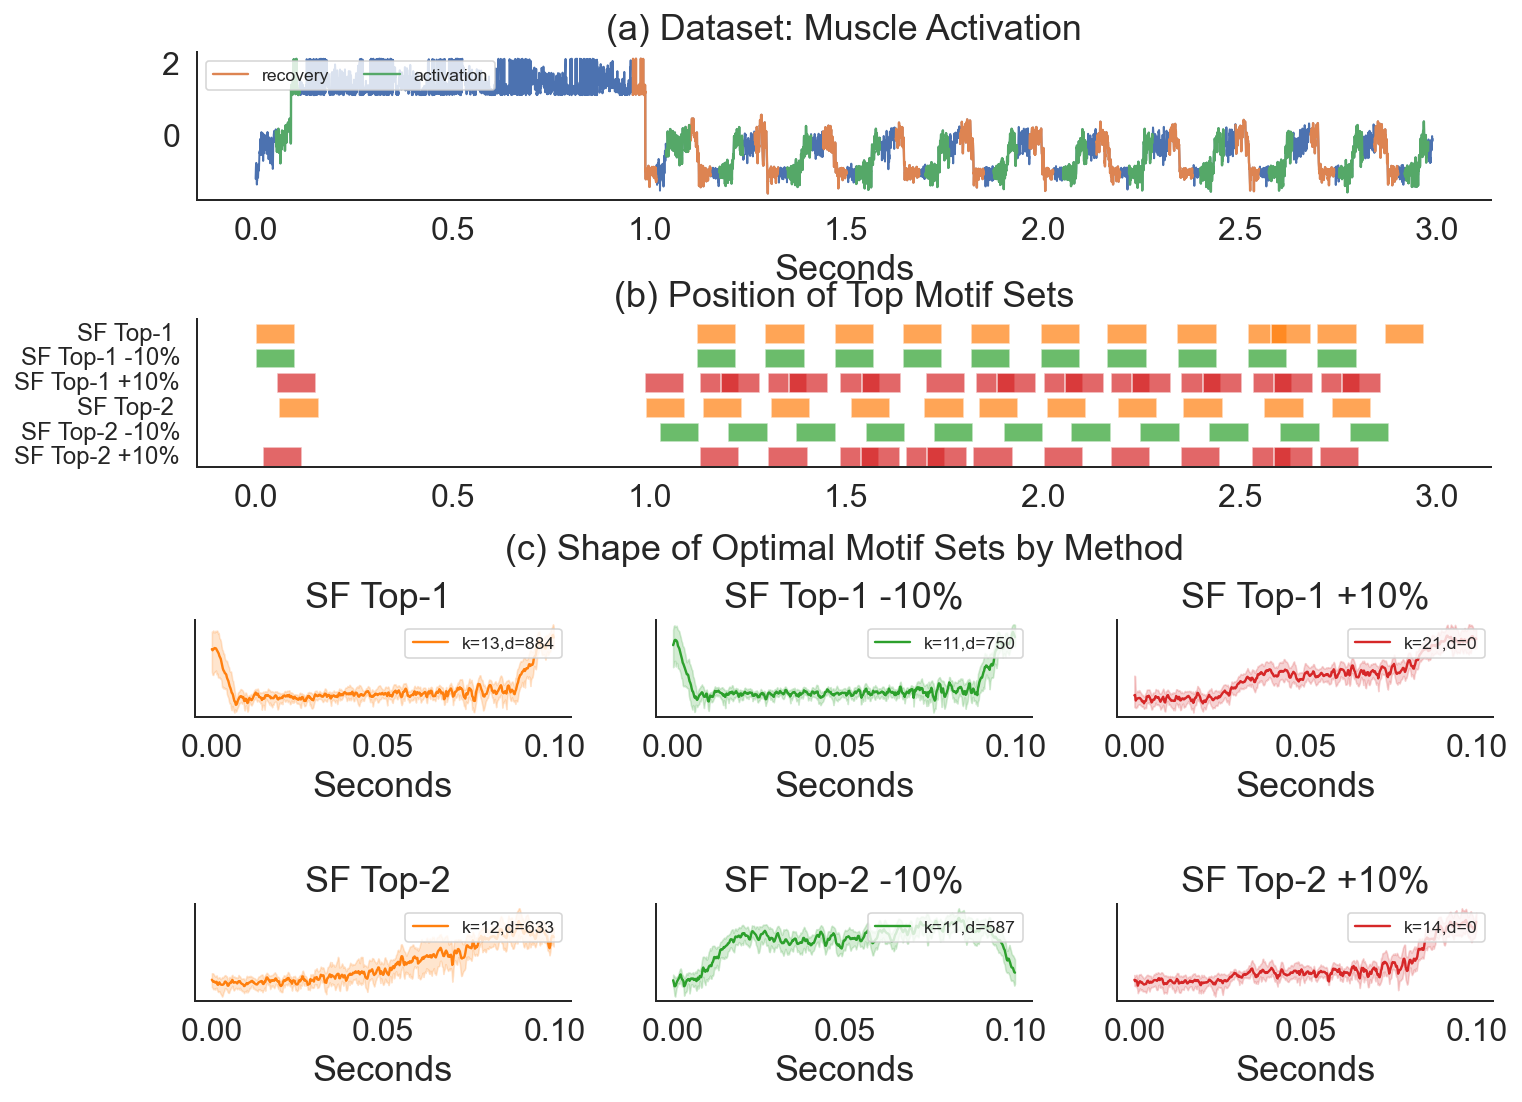

In [9]:
# run jave code first       
ms_all = {
    "" : [
    [8493, 300, 4956, 5680, 6546, 7556, 9186, 10054, 10952, 11782, 12813, 13670], 
    [7, 5600, 6473, 7353, 8219, 9088, 9977, 10818, 11709, 12603, 12903, 13485, 14347],
    ], 
    "-10%" :[
    [13898, 5134, 6004, 6868, 7752, 8613, 9501, 10360, 11237, 12114, 13015],
    [5, 5601, 6474, 7356, 8220, 9088, 9977, 10819, 11711, 12604, 13486],
    ],   
    "+10%" :[
	[90, 5640, 6512, 7419, 7689, 8261, 8531, 9118, 10012, 10865, 11748, 12658, 12932, 13515],
	[8512, 270, 4948, 5641, 5911, 6502, 6772, 7427, 7697, 9147, 9417, 10013, 10283, 10864, 11134, 11760, 12030, 12663, 12933, 13529, 13799],
    ]
}


motifsets = to_df(ms_all, "SF", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)



SF's motifs change little based on parameterization, but only the number of occurences. SF is mostly locked on the activation phase. With optimal parameters, SF finds only activation phases. With noise subtracted, it finds th activation+recovery but with only k=11 occurrences at most.

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [10]:
rs = np.array([r_top2 * 2.8, r_top1 * 1.145])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/emma.jar',
           dataset,
           str(list(rs)),
           str(mls)])

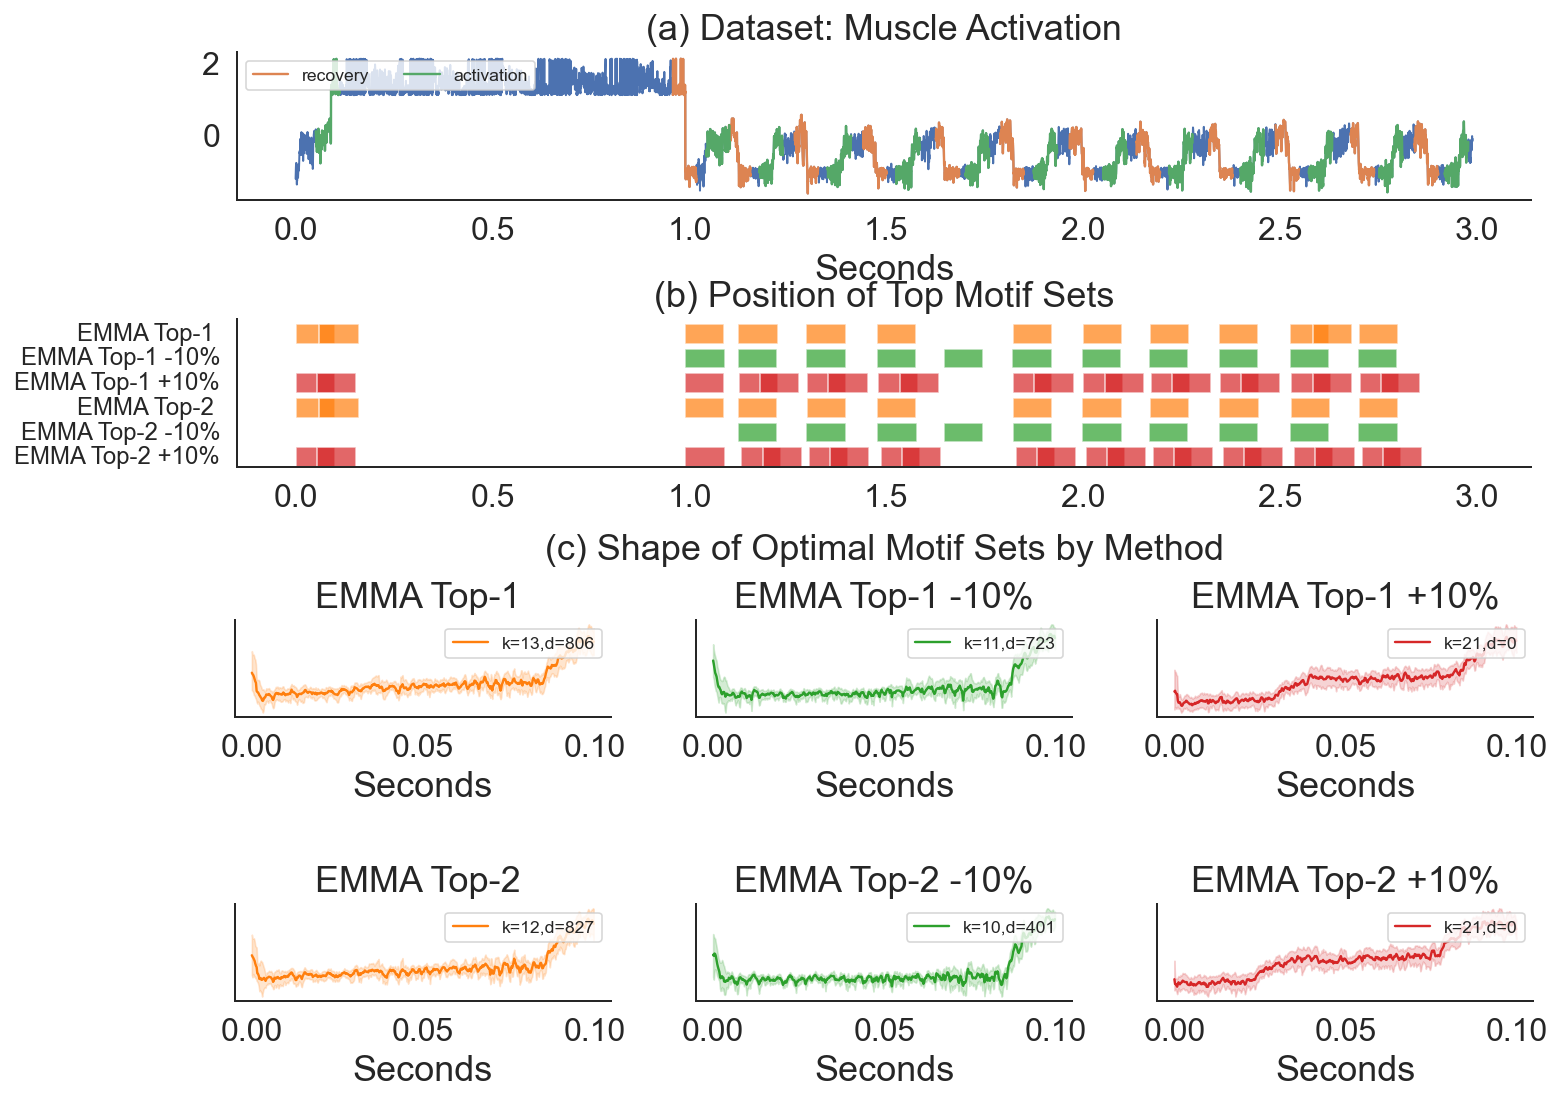

In [11]:
# run jave code first       
ms_all = {
    "" : [
    [0, 300, 4942, 5621, 6491, 7383, 9112, 9993, 10846, 11732, 12641, 13506],
    [0, 300, 4943, 5622, 6489, 7385, 9112, 9997, 10847, 11731, 12624, 12924, 13508],    
    ], 
    "-10%" :[
	[5621, 6488, 7390, 8237, 9107, 9993, 10840, 11729, 12631, 13498],
	[4950, 5620, 6488, 7383, 8237, 9105, 9990, 10840, 11729, 12624, 13495],        
    ],
    "+10%" :[
    [0, 270, 4949, 5663, 5933, 6517, 6787, 7430, 7700, 9144, 9414, 10038, 10308, 10888, 11158, 11774, 12044, 12681, 12951, 13539, 13809],
	[0, 270, 4945, 5629, 5899, 6496, 6766, 7402, 7672, 9112, 9382, 10006, 10276, 10860, 11130, 11739, 12009, 12646, 12916, 13517, 13787],        
    ],    
}


motifsets = to_df(ms_all, "EMMA", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)

EMMA changes little with different parameterization and stays locked on the activation phase and does not find the recovery phase.

# Valmod Motif Sets
based on own (fixed-length) implementation

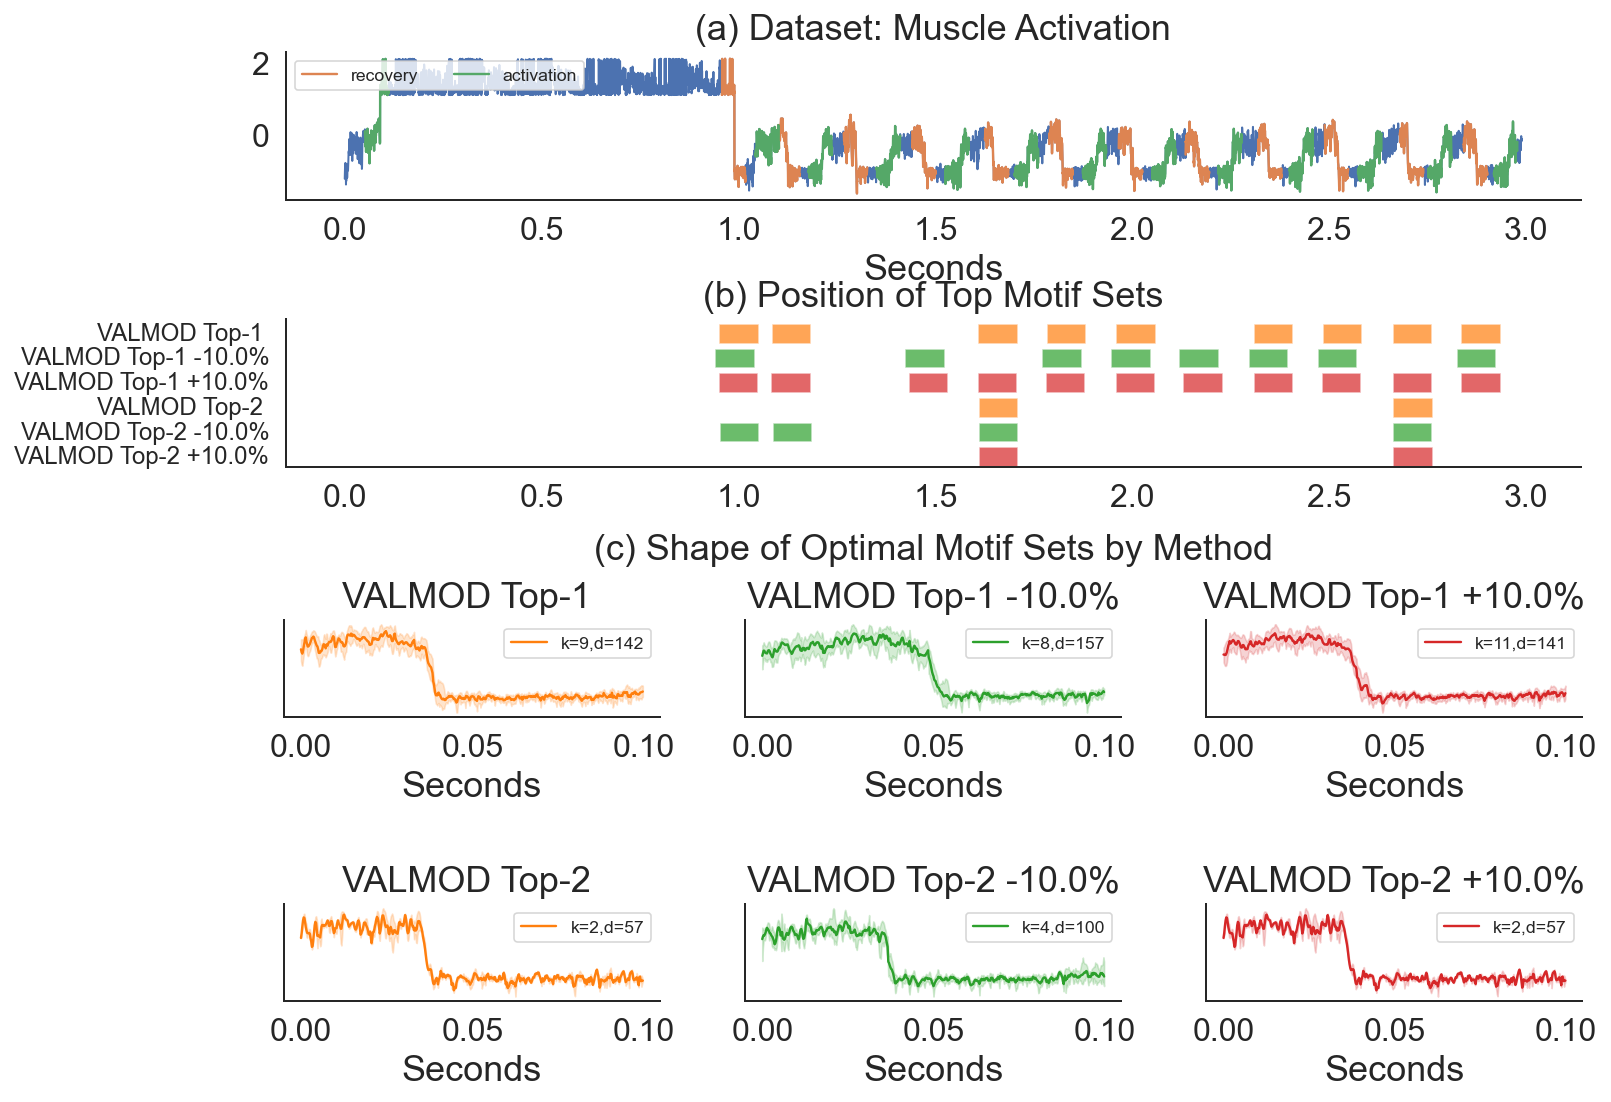

In [12]:
mls = motif_length
max_r=r_top1 * 1.95

ms_all = {}
for e in errors:
    rs = max_r * (1.0 * (1+e))
    #mls = np.int32(motif_length * (1-e))
    ms_valmod = list(get_valmod_motif_set_ranged(data, mls, max_r=rs))
    ms_all[format_key(e)] = ms_valmod
    
    
motifsets = to_df(ms_all, "VALMOD", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)

VALMOD alternates between both motifs depending on parameterization. With optimal parameters, it finds both: activation and recovery.

# Learning Motifs
See Java Code

In [13]:
rs = np.array([r_top2 * 2.8, r_top1 * 1.3])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/latent_motifs.jar',
           dataset,
           str(list(rs)),
           str(mls)])

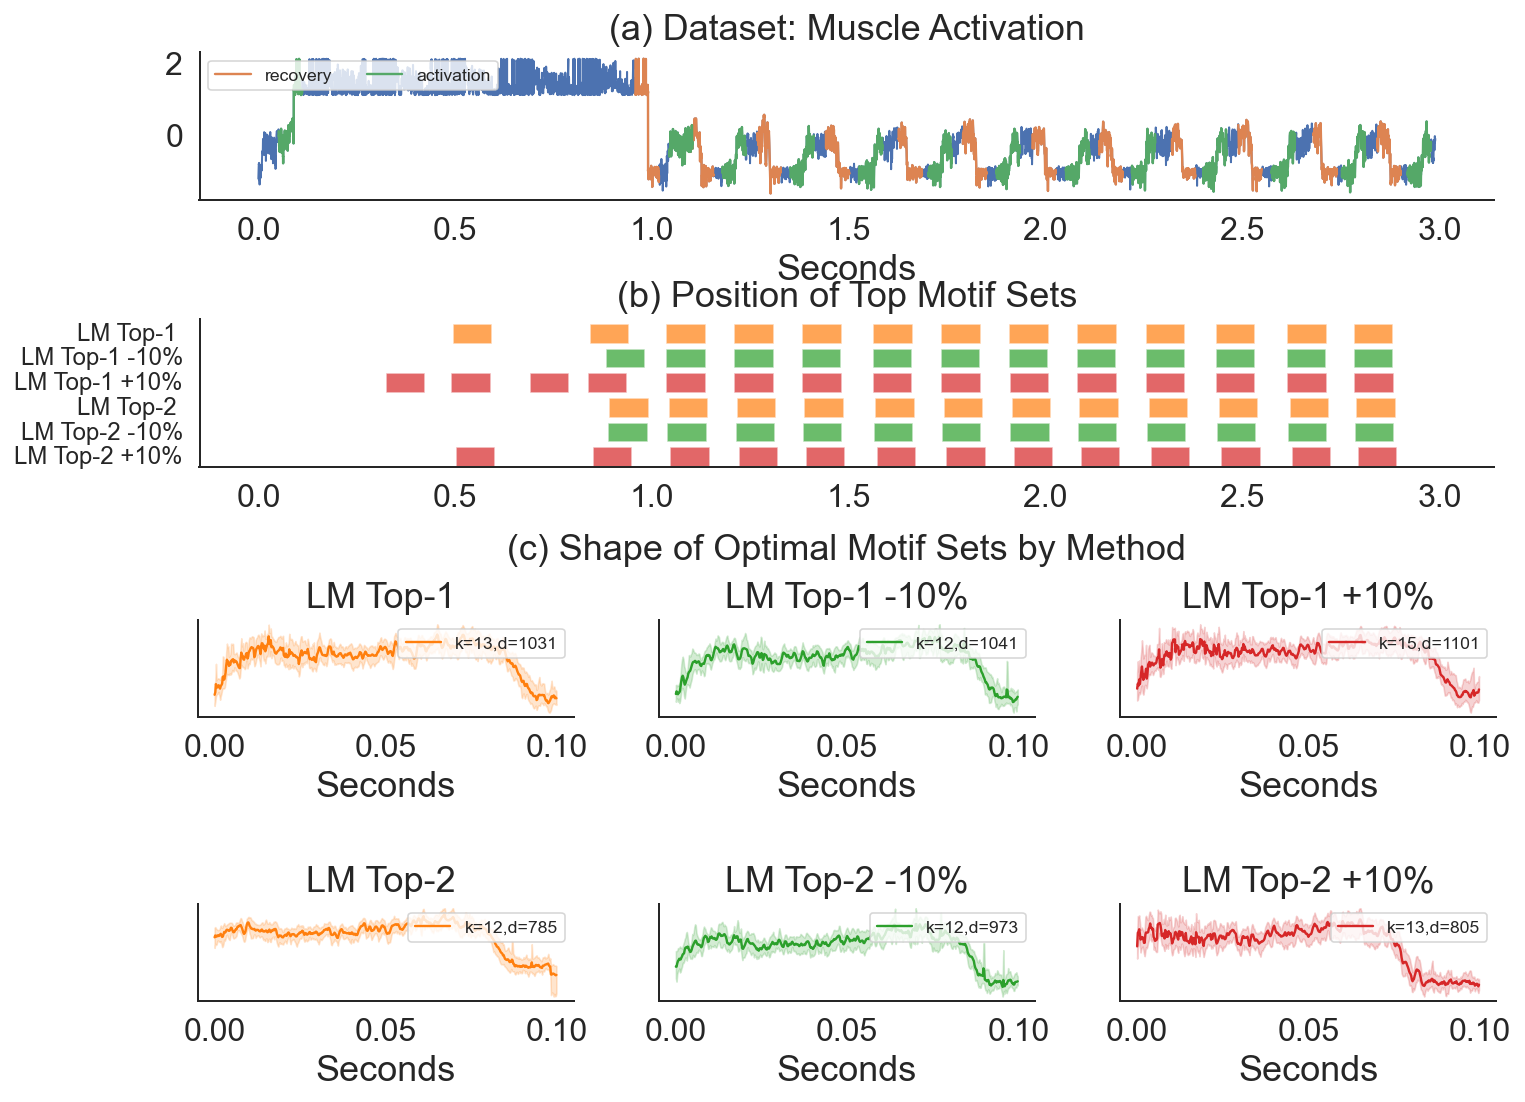

In [14]:
ms_all = {
    "" : [
	[4459,5214,6074,6934,7838,8708,9571,10427,11307,12202,13097,13946,],
	[2472,4209,5183,6045,6910,7810,8675,9540,10404,11268,12165,13068,13918,],
    ], 
    "-10%" : [    
	[4444,5195,6061,6918,7817,8681,9552,10411,11288,12178,13075,13929,],
	[4410,5181,6046,6904,7805,8666,9536,10399,11268,12162,13062,13915,],
    ],        
    "+10%" : [
    [2510,4252,5234,6101,6950,7857,8737,9596,10449,11332,12230,13126,13969,],
	[1620,2453,3446,4181,5183,6045,6911,7809,8674,9542,10404,11271,12165,13068,13919,],        
    ],
}

motifsets = to_df(ms_all, "LM", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)

LM finds the recovery phase even when given different parameterizations.

# Comparison

We next show a comparison of all methods.

Note that the k-Motiflet algorithm has to recover meaningful motifs without any additional knowledge, while the competitors were provided with inputs with near-optimal parameters, and their results rely heavily on parameterization.

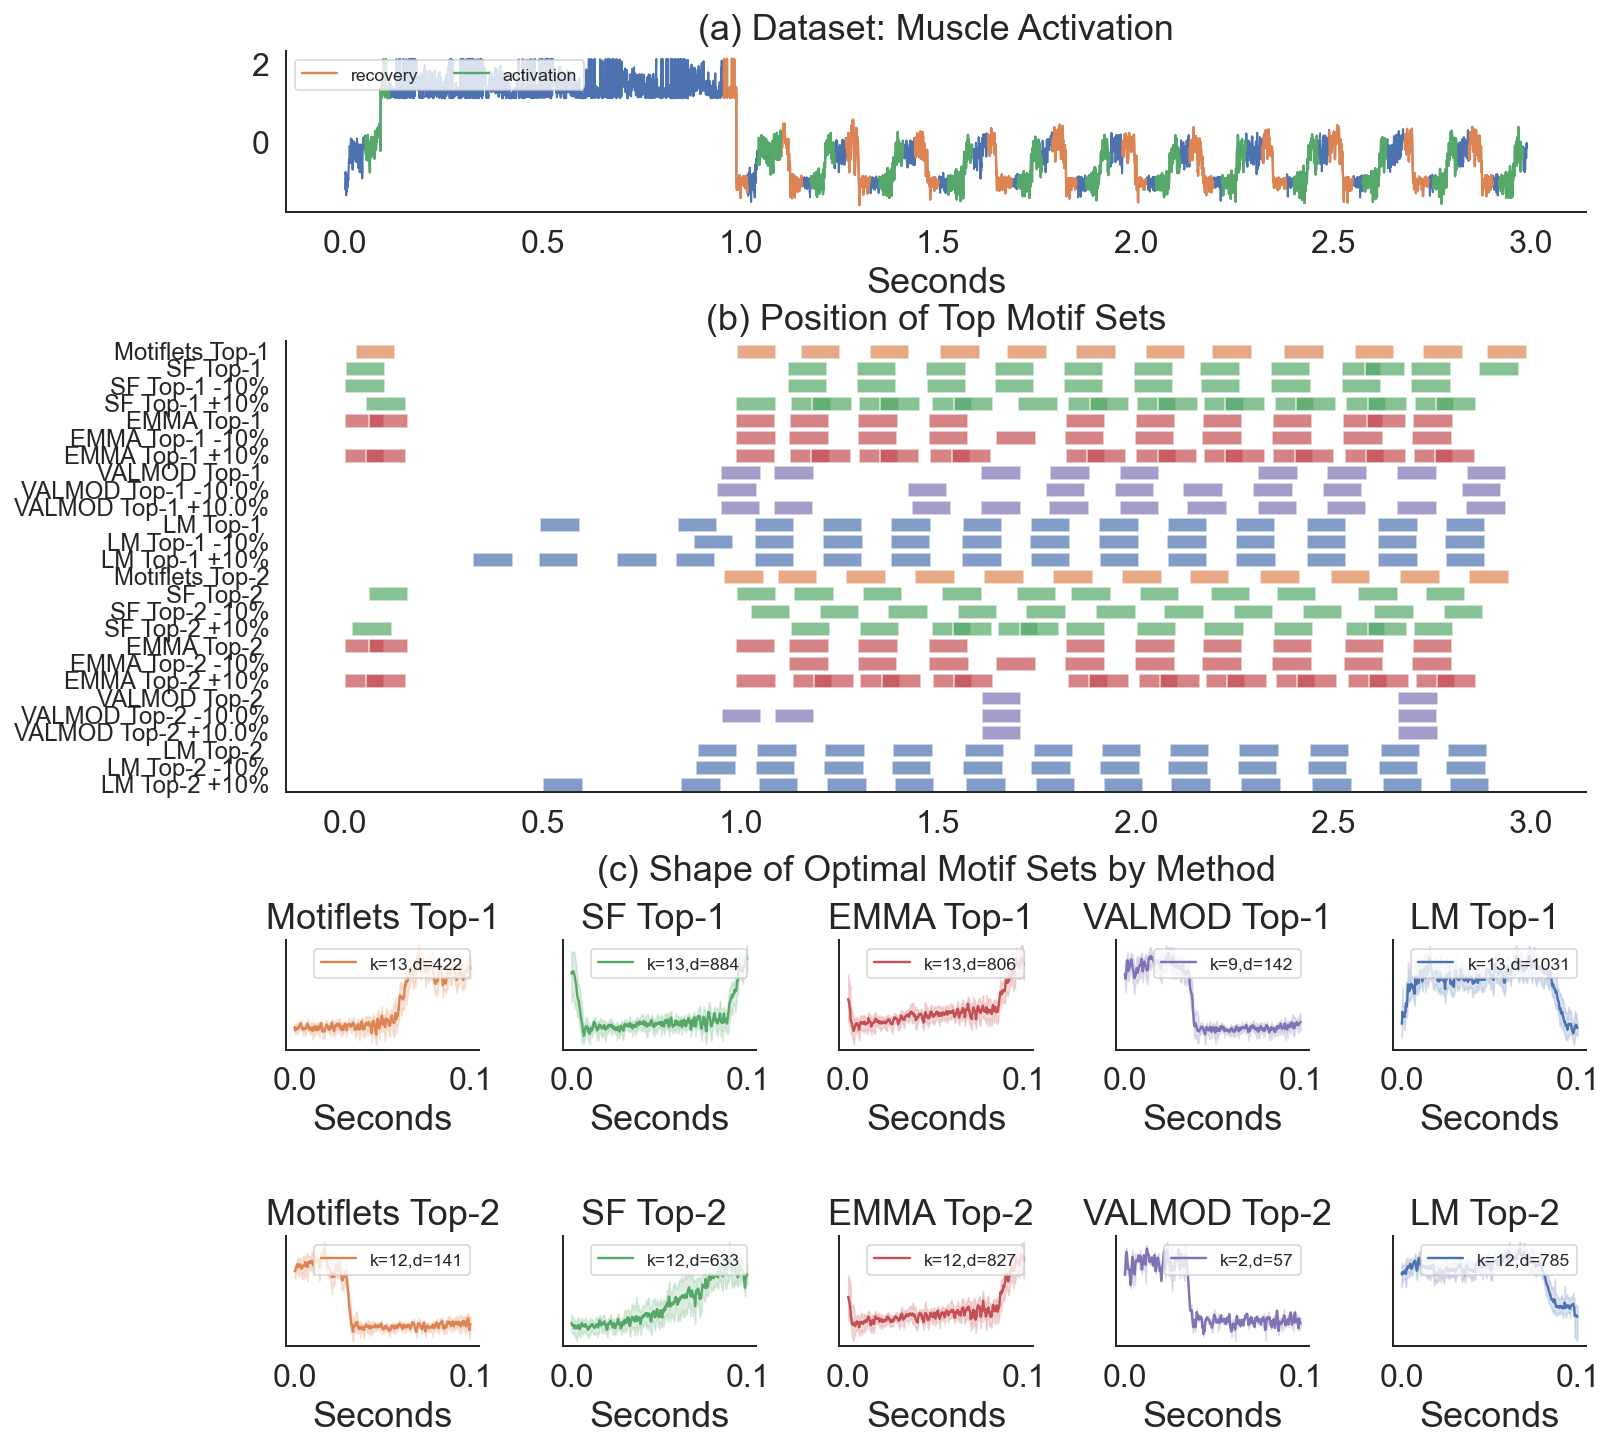

In [15]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)

index = np.array([0, 1, 2, 3, 4])
color_palette=np.array(sns.color_palette())[index]
plot_index=[0, 1, 4, 7, 10, 13, 14, 17, 20, 23]

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, color_palette=color_palette,
                     method_names=df_all.index.values, ground_truth=df_gt, plot_index=plot_index)            

The bottom part of the plot only shows the shape of the optimal motifs, i.e. with optimal parameterization.

Only $k$-Motiflets and VALMOD clearly identify both motifs (recovery and activation). The k-Motiflet algorithm recovered meaningful motifs without any additional knowledge, while  VALMOD was provided with inputs with near-optimal parameters.